# Foundmential AI HW4

* 王华强
* 2016K8009929035

> 2016K8009929035_王华强_04

### Import packages

In [27]:
# coding: utf-8
# ============================================================================
#   Copyright (C) 2017 All rights reserved.
#
#   filename : Logistic_Regression.py
#   author   : chendian / okcd00@qq.com
#   date     : 2018-09-26
#   desc     : Tensorflow Logistic Regression Tutorial
#   
# ============================================================================
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Loading training data from sklearn
> 如果需要使用 sklearn 第三方库中自带的数据集，这里我列出了三种，方便调用与测试

**sklearn的安装**      
```shell
pip install sklearn
```

**调用方法**
+ data = load_data(name='moons')
+ data = load_data(name='circles')
+ data = load_data(name='linear')

如果安装sklearn有困难，也可以直接从文件读取：
+ data = load_data(name='moons', True)
+ data = load_data(name='circles', True)
+ data = load_data(name='linear', True)

In [28]:
# use data from sklearn package
def load_moons():
    from sklearn.datasets import make_moons
    np.random.seed(0)
    X, y = make_moons(800, noise=0.2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_circles():
    from sklearn.datasets import make_circles
    np.random.seed(0)
    X, y = make_circles(800, noise=0.2, factor=0.5, random_state=2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_linear():
    from sklearn.datasets import make_classification
    np.random.seed(0)
    X, y = make_classification(
        800, n_features=2, n_redundant=0, n_informative=1,
        random_state=1, n_clusters_per_class=1)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_data(name='moons', load_directly=False):
    _datasets={
        'moons': load_moons,
        'linear': load_linear,
        'circles': load_circles,
    }
    try:
        ret = pickle.load(open('./{}.pkl'.format(name), 'r')) if load_directly else _datasets[name]()
    except Exception as e:
        print("set name as 'moons', 'linear' or 'circles',\n or check your files' existence")
        print(e)
    return ret

In [29]:
load_data()

dataset shape: (800, 2)


[(array([[-0.60189255,  0.6830404 ],
         [ 0.12608967, -0.30755853],
         [-0.75507775,  0.8834083 ],
         ...,
         [ 1.4073392 , -0.45532892],
         [ 1.7490175 , -0.44402074],
         [-0.25848896,  1.00106769]]),
  array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
         0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
         1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
         0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
         0, 

### Define network
> 此处给出的是逻辑回归(Logistic Regression)的神经网络结构

> 这是原有的LR网络, 线性回归设计见下文

对于输入向量x，其属于类别i的概率为：
$$\begin{align*}
P\left ( Y=i\mid x,W,b \right ) &=softmax_i\left ( Wx+b \right ) \\ 
 &= \frac{e^{W_ix+b_i}}{\sum_{j}e^{W_jx+b_j}}
\end{align*}$$

模型对于输入向量x的预测结果y_pred是所有类别的预测中概率值最大的，即
$$y_{pred}=argmax_iP\left ( Y=i\mid x,W,b \right )$$

在LR模型中，需要求解的参数为权重矩阵W和偏置向量b，为了求解模型的两个参数，首先必须定义损失函数。对于上述的多类别Logistic回归，可以藉由Log似然函数作为其损失函数（**负对数似然** 注意取负）：
$$L\left ( \theta =\left \{ W,b \right \},D \right )=\sum_{i=0}^{\left | D \right |}log\left ( P\left ( Y=y^{\left ( i \right )}\mid x^{\left ( i \right )},W,b  \right ) \right )$$

P.S. 代码中使用的`softmax_cross_entropy(y_truth, logits)`效果为:     
先将`logits`作`softmax`操作获得`y_pred`，然后使用`y_truth`和`y_pred`作负对数似然。

In [30]:
class LogisticRegression():
    def __init__(self, n_in, n_out):
        self.X = tf.placeholder(tf.float32, [None, n_in], name='X')
        self.y = tf.placeholder(tf.int32, [None], name='y')
        self.init_variables(n_in, n_out)
        
    def init_variables(self, n_in, n_out):
        # n_in means n_features
        # n_out means n_classes
        self.W = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_in, n_out]),
            dtype=tf.float32, name='weight')
        self.b = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_out]),
            dtype=tf.float32, name='bias')

    def softmax(self, logits):
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
        return tf.nn.softmax(logits, -1)
        
    def negative_log_likelihood(self, y_pred, y):
        prob = self.sigmoid(y_pred)
        positive_likelihood = tf.log(prob) * y.reshape(-1, 1)
        negative_likelihood = tf.log(1 - prob) * (1 - y.reshape(-1, 1))
        log_likelihood = positive_likelihood + negative_likelihood
        return -tf.reduce_mean(log_likelihood)
    
    def get_network(self):
        hidden = tf.matmul(self.X, self.W) + self.b
        self.y_pred = tf.argmax(self.softmax(hidden), axis=-1)  
        return self.y_pred, hidden
    
    def get_loss(self, hidden):
        # self.loss = self.negative_log_likelihood(y_pred, y)
        # self.loss = tf.nn.sigmoid_cross_entropy_with_logits(pred, y)
        onehot_labels = tf.one_hot(self.y, depth=2)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=hidden)
        return tf.reduce_mean(self.loss)
    
    def gen_input(self, data_x, data_y=None):
        feed_dict = {}
        feed_dict[self.X] = data_x
        if data_y is not None:    
            self.y_truth = data_y
            feed_dict[self.y] = data_y
        return feed_dict
    
    def errors(self, y_pred, y_truth=None):
        if y_truth is None:
            y_truth = self.y
            not_equal_counts = tf.abs(y_pred - y_truth)
            return tf.reduce_mean(not_equal_counts)
        else:
            not_equal_counts = abs(y_pred - y_truth)
            return np.mean(not_equal_counts)

### 线性分类器设计

> 修改上面的代码, 得到一个线性分类器

先给出线性回归(Linear Regression)的网络结构如下:

对于输入向量x，其属于类别i的概率为：
$$\begin{align*}
P\left ( Y=i\mid x,W,b \right ) &=linear\_ normalize\left ( Wx+b \right ) \\ 
 &= \frac{W_ix+b_i}{\sum_{j}\left( W_jx+b_j \right) }
\end{align*}$$

模型对于输入向量x的预测结果y_pred是所有类别的预测中概率值最大的，即
$$y_{pred}=argmax_iP\left ( Y=i\mid x,W,b \right )$$

线性回归模型的损失函数使用均方误差函数, 直接调用`tf.losses.mean_squared_error()`函数.
$$L\left ( \theta =\left \{ W,b \right \},D \right )=\frac{1}{\left | D \right |}\sum_{i=0}^{\left | D \right |} \left( Y_{(i)}-y_{(i)} \right)^2$$


两者的区别参见下文.

In [31]:

class LinearRegression():
    def __init__(self, n_in, n_out):
        self.X = tf.placeholder(tf.float32, [None, n_in], name='X')
        self.y = tf.placeholder(tf.int32, [None], name='y')
        self.init_variables(n_in, n_out)
        
    def init_variables(self, n_in, n_out):
        # n_in means n_features
        # n_out means n_classes
        self.W = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_in, n_out]),
            dtype=tf.float32, name='weight')
        self.b = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_out]),
            dtype=tf.float32, name='bias')

    def linear_normalize(self, input):
        # return tf.exp(input) / tf.reduce_sum(tf.exp(input), -1) #有问题: 维度不对
        # return tf.exp(input) / tf.reduce_sum(tf.exp(input), 0) #应为这样的写法
        # return tf.nn.softmax(input, -1) #应该使用这样的维度
        return  input/tf.reduce_sum(input, 0)
        
    def get_network(self):
        hidden = tf.matmul(self.X, self.W) + self.b
        # self.y_pred = tf.argmax(self.softmax(hidden), axis=-1)  
        self.y_pred = tf.argmax(self.linear_normalize(hidden), axis=-1)  #线性分类的结果非常简单, 每个类别的概率等于线性函数计算的结果. 从中取得最大的即为分类结果.
        return self.y_pred, hidden
    
    def get_loss(self, hidden):
        # self.loss = self.negative_log_likelihood(y_pred, y)
        # self.loss = tf.nn.sigmoid_cross_entropy_with_logits(pred, y)
        onehot_labels = tf.one_hot(self.y, depth=2)
        self.loss = tf.losses.mean_squared_error(labels=onehot_labels, predictions=hidden) #使用均方误差来计算损失函数
        return tf.reduce_mean(self.loss)
    
    def gen_input(self, data_x, data_y=None):
        feed_dict = {}
        feed_dict[self.X] = data_x
        if data_y is not None:    
            self.y_truth = data_y
            feed_dict[self.y] = data_y
        return feed_dict
    
    def errors(self, y_pred, y_truth=None):
        if y_truth is None:
            y_truth = self.y
            not_equal_counts = tf.abs(y_pred - y_truth)
            return tf.reduce_mean(not_equal_counts)
        else:
            not_equal_counts = abs(y_pred - y_truth)
            return np.mean(not_equal_counts)


### Define optimizer
> 因为深度学习常见的是对于梯度的优化，也就是说，     
> 优化器最后其实就是各种对于梯度下降算法的优化。

常见的优化器有 SGD，RMSprop，Adagrad，Adadelta，Adam 等，   
此处实例中使用的是随机梯度下降（Stochastic gradient descent），  
因为大多数机器学习任务就是最小化损失，在损失定义的情况下，后面的工作就交给优化器处理即可

### 这里改用线性分类器进行分类

In [32]:
def sgd_optimization(classifier_class ,datasets, learning_rate=0.10, n_epochs=50, draw_freq=10):
    train_set_x, train_set_y = datasets[0]
    test_set_x,  test_set_y  = datasets[1]
    classifier = classifier_class(n_in=2, n_out=2)  # Classifier: 改为使用线性分类器
    
    def get_model_train():
        with tf.name_scope('train'):
            y_pred, hidden = classifier.get_network()
            loss = classifier.get_loss(hidden)
            return y_pred, loss
    
    def get_model_test():
        with tf.name_scope('test'):
            y_pred, hidden = classifier.get_network()
            return y_pred
        
    train_output = get_model_train()  # y_pred, loss
    test_output = get_model_test()  # y_pred
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(train_output[-1])
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    def call_model(data_x, data_y=None, name=None):
        # generate data_y for placeholder while testing
        if data_y is None:
            data_y = np.zeros(data_x.shape[:-1])
            
        if name == 'test':
            ret = sess.run(  # return y_pred
                test_output,
                feed_dict=classifier.gen_input(data_x, data_y))
        else:  # name == 'train'
            _, ret = sess.run(  # return y_pred, loss
                [optimizer, train_output], 
                feed_dict=classifier.gen_input(data_x, data_y))
        return ret
    
    epoch = 0
    while epoch < n_epochs:
        # draw a figure every 'draw_freq' times
        if epoch % draw_freq == 0:
            # print(train_set_x, train_set_y)
            plot_decision_boundary(
                lambda x: call_model(x)[0], 
                train_set_x, train_set_y)
        
        # print error/cost per epoch
        train_pred, loss = call_model(
            train_set_x, train_set_y, 'train')
        train_error = classifier.errors(
            y_pred=train_pred, y_truth=train_set_y)
        
        test_pred = call_model(
            test_set_x,  test_set_y, 'test')
        test_error = classifier.errors(
            y_pred=test_pred, y_truth=test_set_y)

        print ("epoch is %d, train error %f, test error %f" % (
            epoch, train_error, test_error))
        epoch += 1

    # draw a figure at last        
    plot_decision_boundary(
        lambda x: call_model(x)[0], 
        train_set_x, train_set_y)
    sess.close()


def plot_decision_boundary(pred_func, train_set_x, train_set_y):
    # Draw figures as Matlab 
    x_min, x_max = train_set_x[:, 0].min() - .5, train_set_x[:, 0].max() + .5
    y_min, y_max = train_set_x[:, 1].min() - .5, train_set_x[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_input = np.c_[xx.ravel(), yy.ravel()].reshape([-1, 2])
    Z = pred_func(grid_input)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.scatter(train_set_x[:, 0], train_set_x[:, 1], c=train_set_y, cmap=plt.cm.Spectral)
    plt.show()

### Start Training
> 对于模型选择输入数据（data），设置参数（迭代次数，每N次绘制一次）

### LogisticRegression 和 LinearRegression 在不同训练集上的训练结果

#### MOONS

MOONS数据集在整体上看是可以使用这两种线性分类器进行比较好的分类的. 然而仍然会有一些点无法被线性的分类器区分.

dataset shape: (800, 2)


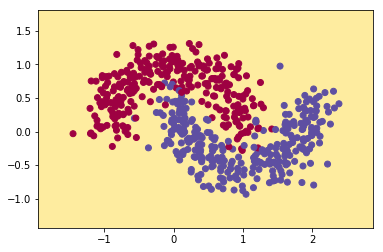

epoch is 0, train error 0.513333, test error 0.185000
epoch is 1, train error 0.206667, test error 0.185000
epoch is 2, train error 0.205000, test error 0.185000
epoch is 3, train error 0.198333, test error 0.185000
epoch is 4, train error 0.196667, test error 0.185000
epoch is 5, train error 0.196667, test error 0.180000
epoch is 6, train error 0.196667, test error 0.180000
epoch is 7, train error 0.196667, test error 0.180000
epoch is 8, train error 0.195000, test error 0.180000
epoch is 9, train error 0.195000, test error 0.180000
epoch is 10, train error 0.195000, test error 0.180000
epoch is 11, train error 0.195000, test error 0.180000
epoch is 12, train error 0.195000, test error 0.175000
epoch is 13, train error 0.195000, test error 0.170000
epoch is 14, train error 0.195000, test error 0.170000
epoch is 15, train error 0.195000, test error 0.165000
epoch is 16, train error 0.193333, test error 0.165000
epoch is 17, train error 0.191667, test error 0.160000
epoch is 18, train e

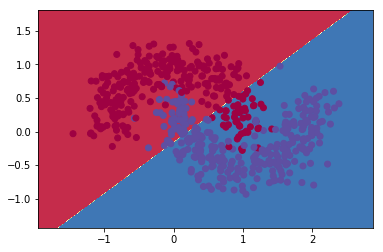

epoch is 25, train error 0.175000, test error 0.155000
epoch is 26, train error 0.176667, test error 0.155000
epoch is 27, train error 0.176667, test error 0.155000
epoch is 28, train error 0.176667, test error 0.155000
epoch is 29, train error 0.178333, test error 0.155000
epoch is 30, train error 0.180000, test error 0.155000
epoch is 31, train error 0.180000, test error 0.155000
epoch is 32, train error 0.178333, test error 0.155000
epoch is 33, train error 0.178333, test error 0.155000
epoch is 34, train error 0.176667, test error 0.155000
epoch is 35, train error 0.176667, test error 0.155000
epoch is 36, train error 0.176667, test error 0.155000
epoch is 37, train error 0.176667, test error 0.155000
epoch is 38, train error 0.176667, test error 0.155000
epoch is 39, train error 0.175000, test error 0.155000
epoch is 40, train error 0.175000, test error 0.155000
epoch is 41, train error 0.175000, test error 0.155000
epoch is 42, train error 0.175000, test error 0.155000
epoch is 4

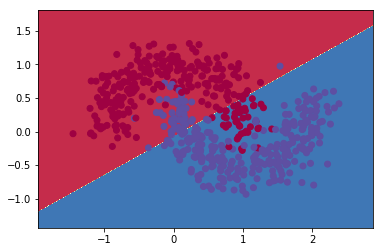

epoch is 50, train error 0.153333, test error 0.145000
epoch is 51, train error 0.153333, test error 0.145000
epoch is 52, train error 0.153333, test error 0.145000
epoch is 53, train error 0.153333, test error 0.145000
epoch is 54, train error 0.156667, test error 0.145000
epoch is 55, train error 0.160000, test error 0.150000
epoch is 56, train error 0.160000, test error 0.150000
epoch is 57, train error 0.160000, test error 0.150000
epoch is 58, train error 0.160000, test error 0.150000
epoch is 59, train error 0.160000, test error 0.150000
epoch is 60, train error 0.160000, test error 0.150000
epoch is 61, train error 0.160000, test error 0.150000
epoch is 62, train error 0.160000, test error 0.150000
epoch is 63, train error 0.160000, test error 0.145000
epoch is 64, train error 0.160000, test error 0.145000
epoch is 65, train error 0.160000, test error 0.145000
epoch is 66, train error 0.160000, test error 0.145000
epoch is 67, train error 0.160000, test error 0.145000
epoch is 6

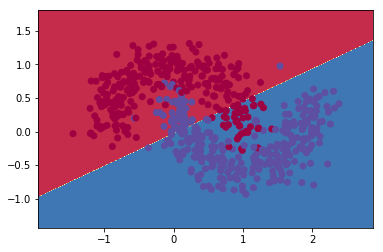

epoch is 75, train error 0.141667, test error 0.135000
epoch is 76, train error 0.145000, test error 0.140000
epoch is 77, train error 0.145000, test error 0.140000
epoch is 78, train error 0.150000, test error 0.140000
epoch is 79, train error 0.153333, test error 0.140000
epoch is 80, train error 0.153333, test error 0.140000
epoch is 81, train error 0.153333, test error 0.140000
epoch is 82, train error 0.153333, test error 0.140000
epoch is 83, train error 0.153333, test error 0.140000
epoch is 84, train error 0.153333, test error 0.140000
epoch is 85, train error 0.153333, test error 0.140000
epoch is 86, train error 0.153333, test error 0.140000
epoch is 87, train error 0.153333, test error 0.140000
epoch is 88, train error 0.153333, test error 0.140000
epoch is 89, train error 0.153333, test error 0.140000
epoch is 90, train error 0.153333, test error 0.140000
epoch is 91, train error 0.153333, test error 0.140000
epoch is 92, train error 0.153333, test error 0.140000
epoch is 9

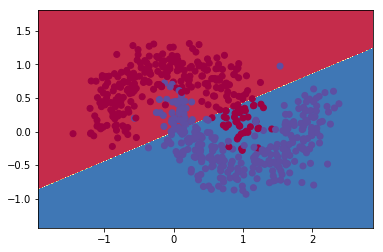

epoch is 100, train error 0.138333, test error 0.130000
epoch is 101, train error 0.138333, test error 0.135000
epoch is 102, train error 0.141667, test error 0.130000
epoch is 103, train error 0.141667, test error 0.135000
epoch is 104, train error 0.143333, test error 0.135000
epoch is 105, train error 0.145000, test error 0.135000
epoch is 106, train error 0.145000, test error 0.140000
epoch is 107, train error 0.145000, test error 0.140000
epoch is 108, train error 0.146667, test error 0.140000
epoch is 109, train error 0.148333, test error 0.140000
epoch is 110, train error 0.150000, test error 0.140000
epoch is 111, train error 0.150000, test error 0.140000
epoch is 112, train error 0.150000, test error 0.140000
epoch is 113, train error 0.151667, test error 0.140000
epoch is 114, train error 0.151667, test error 0.140000
epoch is 115, train error 0.151667, test error 0.140000
epoch is 116, train error 0.151667, test error 0.140000
epoch is 117, train error 0.151667, test error 0

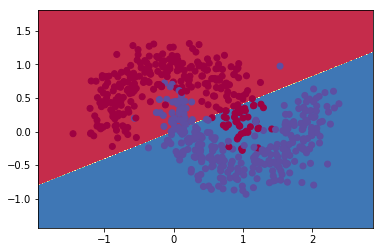

epoch is 125, train error 0.136667, test error 0.130000
epoch is 126, train error 0.135000, test error 0.130000
epoch is 127, train error 0.138333, test error 0.135000
epoch is 128, train error 0.140000, test error 0.135000
epoch is 129, train error 0.141667, test error 0.130000
epoch is 130, train error 0.141667, test error 0.130000
epoch is 131, train error 0.141667, test error 0.135000
epoch is 132, train error 0.143333, test error 0.135000
epoch is 133, train error 0.145000, test error 0.135000
epoch is 134, train error 0.145000, test error 0.135000
epoch is 135, train error 0.145000, test error 0.135000
epoch is 136, train error 0.145000, test error 0.135000
epoch is 137, train error 0.145000, test error 0.135000
epoch is 138, train error 0.145000, test error 0.135000
epoch is 139, train error 0.145000, test error 0.135000
epoch is 140, train error 0.145000, test error 0.135000
epoch is 141, train error 0.145000, test error 0.135000
epoch is 142, train error 0.145000, test error 0

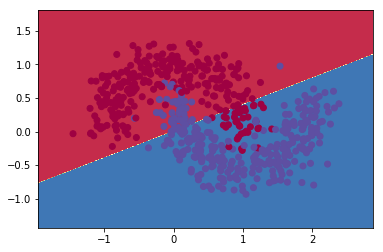

epoch is 150, train error 0.135000, test error 0.130000
epoch is 151, train error 0.136667, test error 0.130000
epoch is 152, train error 0.138333, test error 0.130000
epoch is 153, train error 0.138333, test error 0.135000
epoch is 154, train error 0.140000, test error 0.135000
epoch is 155, train error 0.141667, test error 0.135000
epoch is 156, train error 0.141667, test error 0.130000
epoch is 157, train error 0.141667, test error 0.130000
epoch is 158, train error 0.141667, test error 0.135000
epoch is 159, train error 0.143333, test error 0.135000
epoch is 160, train error 0.143333, test error 0.135000
epoch is 161, train error 0.145000, test error 0.135000
epoch is 162, train error 0.145000, test error 0.135000
epoch is 163, train error 0.145000, test error 0.135000
epoch is 164, train error 0.145000, test error 0.135000
epoch is 165, train error 0.145000, test error 0.135000
epoch is 166, train error 0.145000, test error 0.135000
epoch is 167, train error 0.145000, test error 0

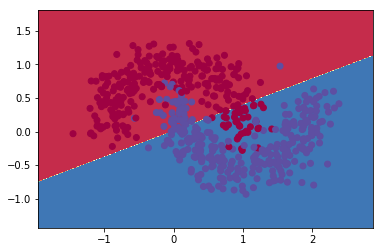

epoch is 175, train error 0.135000, test error 0.130000
epoch is 176, train error 0.136667, test error 0.130000
epoch is 177, train error 0.136667, test error 0.130000
epoch is 178, train error 0.138333, test error 0.130000
epoch is 179, train error 0.138333, test error 0.135000
epoch is 180, train error 0.140000, test error 0.135000
epoch is 181, train error 0.141667, test error 0.135000
epoch is 182, train error 0.141667, test error 0.130000
epoch is 183, train error 0.141667, test error 0.130000
epoch is 184, train error 0.141667, test error 0.130000
epoch is 185, train error 0.141667, test error 0.135000
epoch is 186, train error 0.143333, test error 0.135000
epoch is 187, train error 0.143333, test error 0.135000
epoch is 188, train error 0.143333, test error 0.135000
epoch is 189, train error 0.145000, test error 0.135000
epoch is 190, train error 0.145000, test error 0.135000
epoch is 191, train error 0.145000, test error 0.135000
epoch is 192, train error 0.145000, test error 0

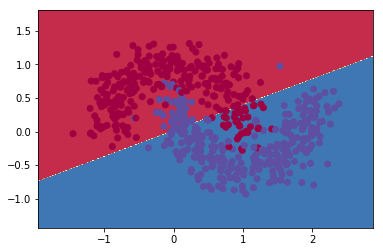

In [33]:
if __name__=="__main__":
    data = load_data('moons')
    sgd_optimization(LinearRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

dataset shape: (800, 2)


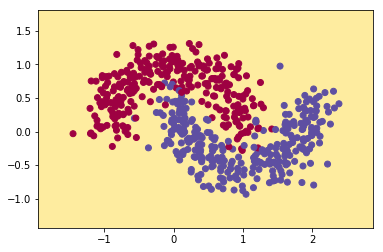

epoch is 0, train error 0.513333, test error 0.460000
epoch is 1, train error 0.513333, test error 0.165000
epoch is 2, train error 0.248333, test error 0.160000
epoch is 3, train error 0.201667, test error 0.175000
epoch is 4, train error 0.215000, test error 0.185000
epoch is 5, train error 0.206667, test error 0.185000
epoch is 6, train error 0.200000, test error 0.185000
epoch is 7, train error 0.200000, test error 0.185000
epoch is 8, train error 0.201667, test error 0.190000
epoch is 9, train error 0.203333, test error 0.190000
epoch is 10, train error 0.198333, test error 0.195000
epoch is 11, train error 0.198333, test error 0.195000
epoch is 12, train error 0.201667, test error 0.195000
epoch is 13, train error 0.201667, test error 0.195000
epoch is 14, train error 0.198333, test error 0.190000
epoch is 15, train error 0.198333, test error 0.190000
epoch is 16, train error 0.198333, test error 0.190000
epoch is 17, train error 0.195000, test error 0.190000
epoch is 18, train e

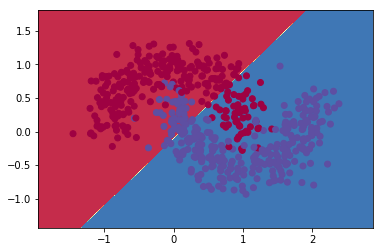

epoch is 25, train error 0.191667, test error 0.175000
epoch is 26, train error 0.193333, test error 0.170000
epoch is 27, train error 0.193333, test error 0.170000
epoch is 28, train error 0.191667, test error 0.165000
epoch is 29, train error 0.191667, test error 0.165000
epoch is 30, train error 0.193333, test error 0.160000
epoch is 31, train error 0.193333, test error 0.160000
epoch is 32, train error 0.193333, test error 0.160000
epoch is 33, train error 0.193333, test error 0.160000
epoch is 34, train error 0.193333, test error 0.160000
epoch is 35, train error 0.193333, test error 0.160000
epoch is 36, train error 0.193333, test error 0.160000
epoch is 37, train error 0.195000, test error 0.160000
epoch is 38, train error 0.195000, test error 0.160000
epoch is 39, train error 0.195000, test error 0.155000
epoch is 40, train error 0.195000, test error 0.155000
epoch is 41, train error 0.195000, test error 0.155000
epoch is 42, train error 0.193333, test error 0.155000
epoch is 4

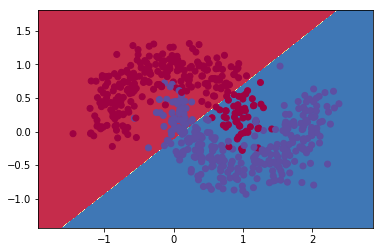

epoch is 50, train error 0.185000, test error 0.165000
epoch is 51, train error 0.185000, test error 0.160000
epoch is 52, train error 0.190000, test error 0.155000
epoch is 53, train error 0.188333, test error 0.155000
epoch is 54, train error 0.190000, test error 0.155000
epoch is 55, train error 0.190000, test error 0.155000
epoch is 56, train error 0.191667, test error 0.160000
epoch is 57, train error 0.190000, test error 0.160000
epoch is 58, train error 0.191667, test error 0.155000
epoch is 59, train error 0.191667, test error 0.160000
epoch is 60, train error 0.191667, test error 0.160000
epoch is 61, train error 0.190000, test error 0.155000
epoch is 62, train error 0.188333, test error 0.155000
epoch is 63, train error 0.188333, test error 0.155000
epoch is 64, train error 0.188333, test error 0.155000
epoch is 65, train error 0.188333, test error 0.155000
epoch is 66, train error 0.188333, test error 0.155000
epoch is 67, train error 0.188333, test error 0.155000
epoch is 6

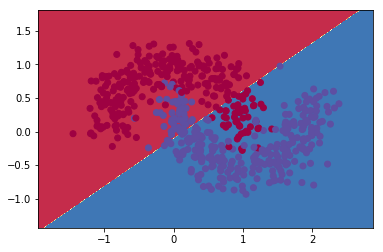

epoch is 75, train error 0.181667, test error 0.155000
epoch is 76, train error 0.183333, test error 0.145000
epoch is 77, train error 0.183333, test error 0.145000
epoch is 78, train error 0.185000, test error 0.150000
epoch is 79, train error 0.185000, test error 0.150000
epoch is 80, train error 0.183333, test error 0.150000
epoch is 81, train error 0.183333, test error 0.150000
epoch is 82, train error 0.183333, test error 0.150000
epoch is 83, train error 0.181667, test error 0.150000
epoch is 84, train error 0.181667, test error 0.150000
epoch is 85, train error 0.181667, test error 0.150000
epoch is 86, train error 0.181667, test error 0.150000
epoch is 87, train error 0.180000, test error 0.150000
epoch is 88, train error 0.180000, test error 0.150000
epoch is 89, train error 0.180000, test error 0.150000
epoch is 90, train error 0.180000, test error 0.150000
epoch is 91, train error 0.178333, test error 0.150000
epoch is 92, train error 0.178333, test error 0.150000
epoch is 9

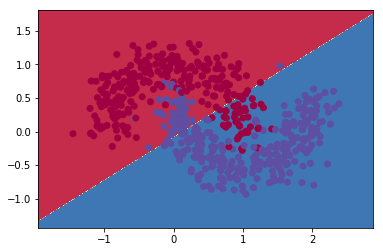

epoch is 100, train error 0.175000, test error 0.140000
epoch is 101, train error 0.175000, test error 0.140000
epoch is 102, train error 0.176667, test error 0.140000
epoch is 103, train error 0.178333, test error 0.140000
epoch is 104, train error 0.181667, test error 0.145000
epoch is 105, train error 0.180000, test error 0.145000
epoch is 106, train error 0.178333, test error 0.145000
epoch is 107, train error 0.178333, test error 0.145000
epoch is 108, train error 0.178333, test error 0.145000
epoch is 109, train error 0.178333, test error 0.145000
epoch is 110, train error 0.176667, test error 0.145000
epoch is 111, train error 0.178333, test error 0.145000
epoch is 112, train error 0.176667, test error 0.145000
epoch is 113, train error 0.175000, test error 0.145000
epoch is 114, train error 0.170000, test error 0.150000
epoch is 115, train error 0.170000, test error 0.150000
epoch is 116, train error 0.170000, test error 0.150000
epoch is 117, train error 0.170000, test error 0

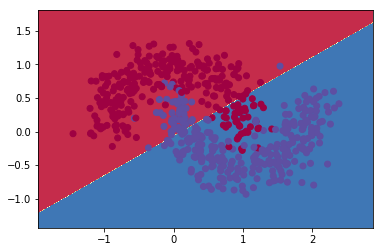

epoch is 125, train error 0.171667, test error 0.135000
epoch is 126, train error 0.173333, test error 0.135000
epoch is 127, train error 0.173333, test error 0.135000
epoch is 128, train error 0.173333, test error 0.135000
epoch is 129, train error 0.173333, test error 0.140000
epoch is 130, train error 0.173333, test error 0.140000
epoch is 131, train error 0.170000, test error 0.140000
epoch is 132, train error 0.170000, test error 0.140000
epoch is 133, train error 0.173333, test error 0.145000
epoch is 134, train error 0.173333, test error 0.145000
epoch is 135, train error 0.170000, test error 0.145000
epoch is 136, train error 0.170000, test error 0.145000
epoch is 137, train error 0.170000, test error 0.145000
epoch is 138, train error 0.170000, test error 0.145000
epoch is 139, train error 0.168333, test error 0.145000
epoch is 140, train error 0.166667, test error 0.145000
epoch is 141, train error 0.166667, test error 0.145000
epoch is 142, train error 0.166667, test error 0

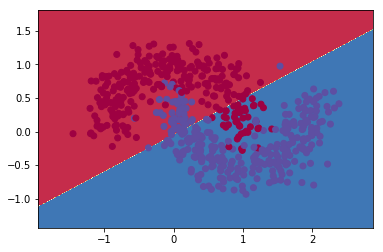

epoch is 150, train error 0.170000, test error 0.135000
epoch is 151, train error 0.168333, test error 0.135000
epoch is 152, train error 0.168333, test error 0.135000
epoch is 153, train error 0.165000, test error 0.135000
epoch is 154, train error 0.165000, test error 0.135000
epoch is 155, train error 0.165000, test error 0.135000
epoch is 156, train error 0.160000, test error 0.135000
epoch is 157, train error 0.161667, test error 0.135000
epoch is 158, train error 0.161667, test error 0.135000
epoch is 159, train error 0.165000, test error 0.140000
epoch is 160, train error 0.166667, test error 0.140000
epoch is 161, train error 0.166667, test error 0.140000
epoch is 162, train error 0.168333, test error 0.145000
epoch is 163, train error 0.166667, test error 0.145000
epoch is 164, train error 0.165000, test error 0.145000
epoch is 165, train error 0.163333, test error 0.145000
epoch is 166, train error 0.163333, test error 0.145000
epoch is 167, train error 0.163333, test error 0

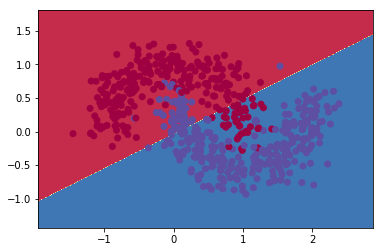

epoch is 175, train error 0.165000, test error 0.130000
epoch is 176, train error 0.163333, test error 0.135000
epoch is 177, train error 0.160000, test error 0.135000
epoch is 178, train error 0.160000, test error 0.135000
epoch is 179, train error 0.160000, test error 0.135000
epoch is 180, train error 0.158333, test error 0.135000
epoch is 181, train error 0.158333, test error 0.135000
epoch is 182, train error 0.156667, test error 0.135000
epoch is 183, train error 0.156667, test error 0.135000
epoch is 184, train error 0.158333, test error 0.135000
epoch is 185, train error 0.158333, test error 0.135000
epoch is 186, train error 0.158333, test error 0.135000
epoch is 187, train error 0.160000, test error 0.135000
epoch is 188, train error 0.160000, test error 0.135000
epoch is 189, train error 0.160000, test error 0.135000
epoch is 190, train error 0.158333, test error 0.140000
epoch is 191, train error 0.160000, test error 0.140000
epoch is 192, train error 0.160000, test error 0

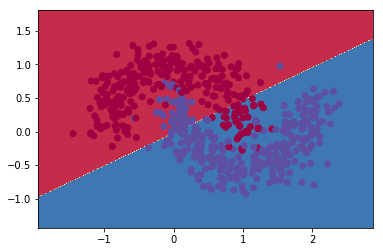

In [34]:
if __name__=="__main__":
    data = load_data('moons')
    sgd_optimization(LogisticRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

相比于线性回归在整个梯度下降过程中表现的比较稳定, LogisticRegression收敛的速度较慢, 且在收敛的过程中出现了较明显的周期性和波动.从最后结果上看也要稍弱于线性分类器. 怀疑这种现象与学习率的设置有关, 调整学习速率进行下一步测试如下:

dataset shape: (800, 2)


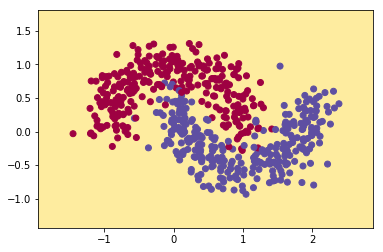

epoch is 0, train error 0.513333, test error 0.460000
epoch is 1, train error 0.513333, test error 0.205000
epoch is 2, train error 0.271667, test error 0.160000
epoch is 3, train error 0.205000, test error 0.170000
epoch is 4, train error 0.211667, test error 0.185000
epoch is 5, train error 0.205000, test error 0.180000
epoch is 6, train error 0.196667, test error 0.180000
epoch is 7, train error 0.200000, test error 0.190000
epoch is 8, train error 0.201667, test error 0.190000
epoch is 9, train error 0.205000, test error 0.195000
epoch is 10, train error 0.200000, test error 0.195000
epoch is 11, train error 0.206667, test error 0.195000
epoch is 12, train error 0.208333, test error 0.200000
epoch is 13, train error 0.213333, test error 0.205000
epoch is 14, train error 0.210000, test error 0.200000
epoch is 15, train error 0.208333, test error 0.205000
epoch is 16, train error 0.208333, test error 0.205000
epoch is 17, train error 0.208333, test error 0.205000
epoch is 18, train e

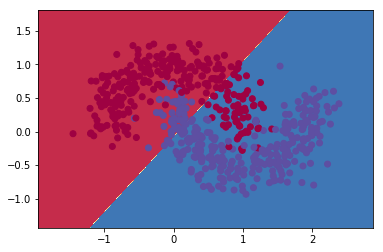

epoch is 25, train error 0.198333, test error 0.175000
epoch is 26, train error 0.198333, test error 0.175000
epoch is 27, train error 0.198333, test error 0.175000
epoch is 28, train error 0.200000, test error 0.175000
epoch is 29, train error 0.200000, test error 0.180000
epoch is 30, train error 0.200000, test error 0.180000
epoch is 31, train error 0.200000, test error 0.180000
epoch is 32, train error 0.200000, test error 0.180000
epoch is 33, train error 0.196667, test error 0.180000
epoch is 34, train error 0.195000, test error 0.180000
epoch is 35, train error 0.195000, test error 0.180000
epoch is 36, train error 0.193333, test error 0.180000
epoch is 37, train error 0.193333, test error 0.180000
epoch is 38, train error 0.193333, test error 0.180000
epoch is 39, train error 0.193333, test error 0.180000
epoch is 40, train error 0.193333, test error 0.180000
epoch is 41, train error 0.193333, test error 0.180000
epoch is 42, train error 0.193333, test error 0.175000
epoch is 4

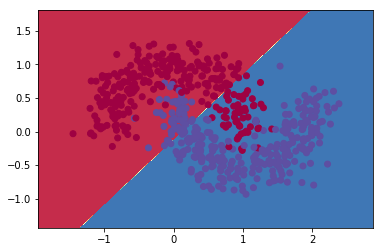

epoch is 50, train error 0.193333, test error 0.160000
epoch is 51, train error 0.193333, test error 0.160000
epoch is 52, train error 0.193333, test error 0.165000
epoch is 53, train error 0.195000, test error 0.165000
epoch is 54, train error 0.195000, test error 0.165000
epoch is 55, train error 0.195000, test error 0.170000
epoch is 56, train error 0.195000, test error 0.170000
epoch is 57, train error 0.195000, test error 0.170000
epoch is 58, train error 0.195000, test error 0.170000
epoch is 59, train error 0.195000, test error 0.175000
epoch is 60, train error 0.195000, test error 0.175000
epoch is 61, train error 0.195000, test error 0.175000
epoch is 62, train error 0.195000, test error 0.175000
epoch is 63, train error 0.195000, test error 0.175000
epoch is 64, train error 0.195000, test error 0.175000
epoch is 65, train error 0.195000, test error 0.175000
epoch is 66, train error 0.195000, test error 0.175000
epoch is 67, train error 0.195000, test error 0.175000
epoch is 6

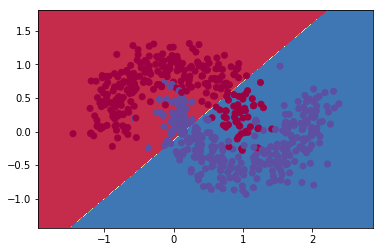

epoch is 75, train error 0.190000, test error 0.160000
epoch is 76, train error 0.190000, test error 0.160000
epoch is 77, train error 0.190000, test error 0.160000
epoch is 78, train error 0.190000, test error 0.160000
epoch is 79, train error 0.190000, test error 0.160000
epoch is 80, train error 0.191667, test error 0.160000
epoch is 81, train error 0.191667, test error 0.160000
epoch is 82, train error 0.191667, test error 0.160000
epoch is 83, train error 0.191667, test error 0.160000
epoch is 84, train error 0.191667, test error 0.160000
epoch is 85, train error 0.191667, test error 0.160000
epoch is 86, train error 0.191667, test error 0.160000
epoch is 87, train error 0.191667, test error 0.160000
epoch is 88, train error 0.191667, test error 0.160000
epoch is 89, train error 0.191667, test error 0.155000
epoch is 90, train error 0.191667, test error 0.155000
epoch is 91, train error 0.191667, test error 0.155000
epoch is 92, train error 0.193333, test error 0.155000
epoch is 9

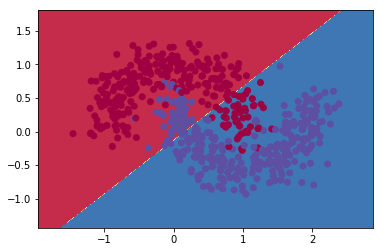

epoch is 100, train error 0.191667, test error 0.160000
epoch is 101, train error 0.193333, test error 0.160000
epoch is 102, train error 0.193333, test error 0.165000
epoch is 103, train error 0.190000, test error 0.165000
epoch is 104, train error 0.190000, test error 0.165000
epoch is 105, train error 0.190000, test error 0.165000
epoch is 106, train error 0.190000, test error 0.165000
epoch is 107, train error 0.190000, test error 0.165000
epoch is 108, train error 0.190000, test error 0.155000
epoch is 109, train error 0.190000, test error 0.155000
epoch is 110, train error 0.190000, test error 0.155000
epoch is 111, train error 0.190000, test error 0.155000
epoch is 112, train error 0.190000, test error 0.155000
epoch is 113, train error 0.190000, test error 0.155000
epoch is 114, train error 0.188333, test error 0.155000
epoch is 115, train error 0.188333, test error 0.155000
epoch is 116, train error 0.188333, test error 0.155000
epoch is 117, train error 0.188333, test error 0

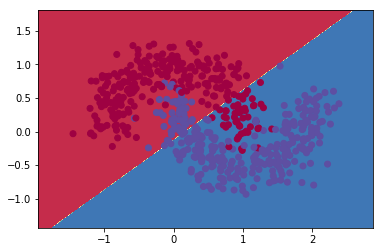

epoch is 125, train error 0.188333, test error 0.155000
epoch is 126, train error 0.188333, test error 0.150000
epoch is 127, train error 0.188333, test error 0.150000
epoch is 128, train error 0.188333, test error 0.150000
epoch is 129, train error 0.186667, test error 0.150000
epoch is 130, train error 0.186667, test error 0.150000
epoch is 131, train error 0.186667, test error 0.150000
epoch is 132, train error 0.188333, test error 0.150000
epoch is 133, train error 0.185000, test error 0.150000
epoch is 134, train error 0.185000, test error 0.150000
epoch is 135, train error 0.186667, test error 0.150000
epoch is 136, train error 0.186667, test error 0.150000
epoch is 137, train error 0.188333, test error 0.150000
epoch is 138, train error 0.188333, test error 0.150000
epoch is 139, train error 0.188333, test error 0.155000
epoch is 140, train error 0.188333, test error 0.155000
epoch is 141, train error 0.190000, test error 0.155000
epoch is 142, train error 0.190000, test error 0

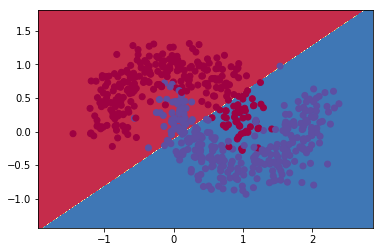

epoch is 150, train error 0.185000, test error 0.150000
epoch is 151, train error 0.185000, test error 0.150000
epoch is 152, train error 0.183333, test error 0.150000
epoch is 153, train error 0.183333, test error 0.150000
epoch is 154, train error 0.183333, test error 0.150000
epoch is 155, train error 0.181667, test error 0.150000
epoch is 156, train error 0.181667, test error 0.150000
epoch is 157, train error 0.181667, test error 0.150000
epoch is 158, train error 0.181667, test error 0.150000
epoch is 159, train error 0.181667, test error 0.150000
epoch is 160, train error 0.181667, test error 0.150000
epoch is 161, train error 0.185000, test error 0.150000
epoch is 162, train error 0.183333, test error 0.150000
epoch is 163, train error 0.183333, test error 0.150000
epoch is 164, train error 0.183333, test error 0.150000
epoch is 165, train error 0.183333, test error 0.150000
epoch is 166, train error 0.183333, test error 0.150000
epoch is 167, train error 0.183333, test error 0

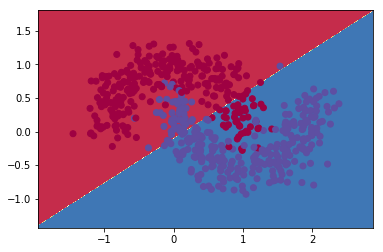

epoch is 175, train error 0.181667, test error 0.145000
epoch is 176, train error 0.183333, test error 0.150000
epoch is 177, train error 0.183333, test error 0.150000
epoch is 178, train error 0.183333, test error 0.150000
epoch is 179, train error 0.181667, test error 0.150000
epoch is 180, train error 0.181667, test error 0.150000
epoch is 181, train error 0.181667, test error 0.150000
epoch is 182, train error 0.181667, test error 0.150000
epoch is 183, train error 0.181667, test error 0.150000
epoch is 184, train error 0.181667, test error 0.150000
epoch is 185, train error 0.181667, test error 0.150000
epoch is 186, train error 0.180000, test error 0.150000
epoch is 187, train error 0.180000, test error 0.150000
epoch is 188, train error 0.180000, test error 0.150000
epoch is 189, train error 0.180000, test error 0.150000
epoch is 190, train error 0.176667, test error 0.150000
epoch is 191, train error 0.176667, test error 0.150000
epoch is 192, train error 0.176667, test error 0

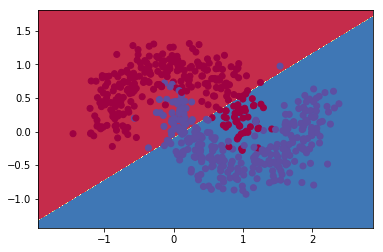

epoch is 200, train error 0.180000, test error 0.145000
epoch is 201, train error 0.180000, test error 0.145000
epoch is 202, train error 0.180000, test error 0.145000
epoch is 203, train error 0.178333, test error 0.145000
epoch is 204, train error 0.178333, test error 0.145000
epoch is 205, train error 0.178333, test error 0.145000
epoch is 206, train error 0.178333, test error 0.145000
epoch is 207, train error 0.180000, test error 0.145000
epoch is 208, train error 0.180000, test error 0.145000
epoch is 209, train error 0.180000, test error 0.145000
epoch is 210, train error 0.180000, test error 0.145000
epoch is 211, train error 0.178333, test error 0.145000
epoch is 212, train error 0.178333, test error 0.150000
epoch is 213, train error 0.178333, test error 0.150000
epoch is 214, train error 0.176667, test error 0.150000
epoch is 215, train error 0.176667, test error 0.150000
epoch is 216, train error 0.176667, test error 0.150000
epoch is 217, train error 0.175000, test error 0

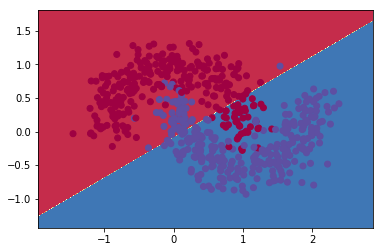

epoch is 225, train error 0.180000, test error 0.145000
epoch is 226, train error 0.176667, test error 0.145000
epoch is 227, train error 0.176667, test error 0.145000
epoch is 228, train error 0.176667, test error 0.145000
epoch is 229, train error 0.178333, test error 0.145000
epoch is 230, train error 0.178333, test error 0.145000
epoch is 231, train error 0.176667, test error 0.145000
epoch is 232, train error 0.176667, test error 0.145000
epoch is 233, train error 0.176667, test error 0.145000
epoch is 234, train error 0.175000, test error 0.145000
epoch is 235, train error 0.175000, test error 0.145000
epoch is 236, train error 0.173333, test error 0.145000
epoch is 237, train error 0.173333, test error 0.145000
epoch is 238, train error 0.173333, test error 0.145000
epoch is 239, train error 0.171667, test error 0.145000
epoch is 240, train error 0.170000, test error 0.145000
epoch is 241, train error 0.171667, test error 0.145000
epoch is 242, train error 0.171667, test error 0

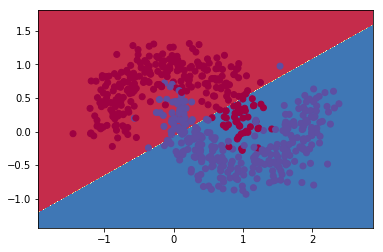

epoch is 250, train error 0.175000, test error 0.140000
epoch is 251, train error 0.173333, test error 0.140000
epoch is 252, train error 0.173333, test error 0.140000
epoch is 253, train error 0.173333, test error 0.140000
epoch is 254, train error 0.173333, test error 0.145000
epoch is 255, train error 0.173333, test error 0.145000
epoch is 256, train error 0.173333, test error 0.145000
epoch is 257, train error 0.173333, test error 0.145000
epoch is 258, train error 0.173333, test error 0.145000
epoch is 259, train error 0.173333, test error 0.145000
epoch is 260, train error 0.170000, test error 0.145000
epoch is 261, train error 0.170000, test error 0.145000
epoch is 262, train error 0.170000, test error 0.145000
epoch is 263, train error 0.170000, test error 0.145000
epoch is 264, train error 0.170000, test error 0.145000
epoch is 265, train error 0.170000, test error 0.145000
epoch is 266, train error 0.170000, test error 0.145000
epoch is 267, train error 0.170000, test error 0

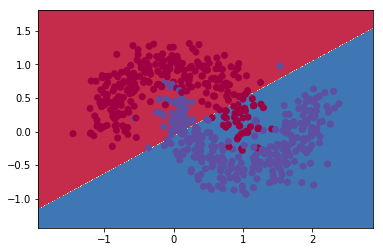

epoch is 275, train error 0.170000, test error 0.140000
epoch is 276, train error 0.166667, test error 0.140000
epoch is 277, train error 0.168333, test error 0.140000
epoch is 278, train error 0.168333, test error 0.140000
epoch is 279, train error 0.168333, test error 0.140000
epoch is 280, train error 0.168333, test error 0.140000
epoch is 281, train error 0.168333, test error 0.140000
epoch is 282, train error 0.168333, test error 0.140000
epoch is 283, train error 0.170000, test error 0.140000
epoch is 284, train error 0.170000, test error 0.145000
epoch is 285, train error 0.170000, test error 0.145000
epoch is 286, train error 0.170000, test error 0.145000
epoch is 287, train error 0.168333, test error 0.145000
epoch is 288, train error 0.168333, test error 0.145000
epoch is 289, train error 0.168333, test error 0.145000
epoch is 290, train error 0.168333, test error 0.145000
epoch is 291, train error 0.168333, test error 0.145000
epoch is 292, train error 0.168333, test error 0

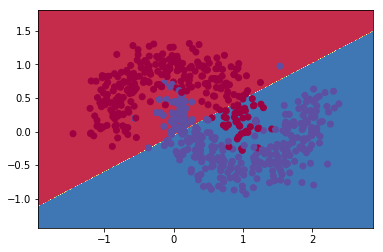

epoch is 300, train error 0.166667, test error 0.135000
epoch is 301, train error 0.163333, test error 0.135000
epoch is 302, train error 0.161667, test error 0.135000
epoch is 303, train error 0.163333, test error 0.135000
epoch is 304, train error 0.161667, test error 0.135000
epoch is 305, train error 0.163333, test error 0.135000
epoch is 306, train error 0.165000, test error 0.140000
epoch is 307, train error 0.166667, test error 0.140000
epoch is 308, train error 0.166667, test error 0.140000
epoch is 309, train error 0.166667, test error 0.140000
epoch is 310, train error 0.166667, test error 0.140000
epoch is 311, train error 0.166667, test error 0.140000
epoch is 312, train error 0.168333, test error 0.140000
epoch is 313, train error 0.168333, test error 0.145000
epoch is 314, train error 0.168333, test error 0.145000
epoch is 315, train error 0.168333, test error 0.145000
epoch is 316, train error 0.168333, test error 0.145000
epoch is 317, train error 0.168333, test error 0

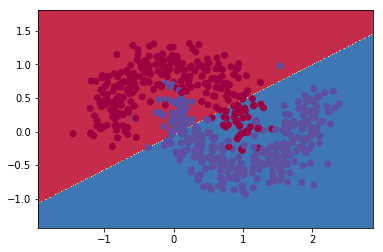

epoch is 325, train error 0.160000, test error 0.135000
epoch is 326, train error 0.160000, test error 0.135000
epoch is 327, train error 0.160000, test error 0.135000
epoch is 328, train error 0.160000, test error 0.135000
epoch is 329, train error 0.161667, test error 0.135000
epoch is 330, train error 0.161667, test error 0.135000
epoch is 331, train error 0.163333, test error 0.135000
epoch is 332, train error 0.163333, test error 0.135000
epoch is 333, train error 0.163333, test error 0.135000
epoch is 334, train error 0.166667, test error 0.135000
epoch is 335, train error 0.166667, test error 0.135000
epoch is 336, train error 0.166667, test error 0.140000
epoch is 337, train error 0.166667, test error 0.140000
epoch is 338, train error 0.163333, test error 0.140000
epoch is 339, train error 0.163333, test error 0.140000
epoch is 340, train error 0.163333, test error 0.140000
epoch is 341, train error 0.165000, test error 0.140000
epoch is 342, train error 0.165000, test error 0

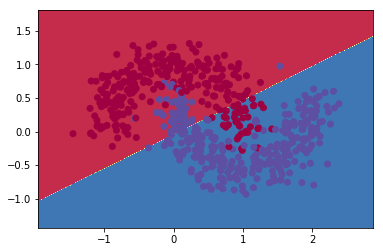

epoch is 350, train error 0.158333, test error 0.135000
epoch is 351, train error 0.158333, test error 0.135000
epoch is 352, train error 0.158333, test error 0.135000
epoch is 353, train error 0.158333, test error 0.135000
epoch is 354, train error 0.158333, test error 0.135000
epoch is 355, train error 0.160000, test error 0.135000
epoch is 356, train error 0.163333, test error 0.135000
epoch is 357, train error 0.163333, test error 0.135000
epoch is 358, train error 0.160000, test error 0.135000
epoch is 359, train error 0.158333, test error 0.135000
epoch is 360, train error 0.158333, test error 0.135000
epoch is 361, train error 0.160000, test error 0.135000
epoch is 362, train error 0.160000, test error 0.135000
epoch is 363, train error 0.161667, test error 0.135000
epoch is 364, train error 0.161667, test error 0.135000
epoch is 365, train error 0.161667, test error 0.135000
epoch is 366, train error 0.161667, test error 0.135000
epoch is 367, train error 0.161667, test error 0

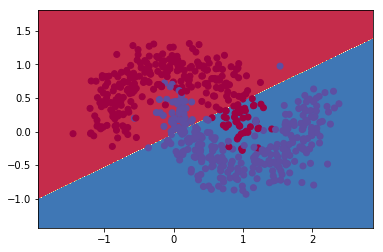

epoch is 375, train error 0.156667, test error 0.135000
epoch is 376, train error 0.156667, test error 0.135000
epoch is 377, train error 0.156667, test error 0.135000
epoch is 378, train error 0.156667, test error 0.135000
epoch is 379, train error 0.153333, test error 0.135000
epoch is 380, train error 0.153333, test error 0.135000
epoch is 381, train error 0.155000, test error 0.135000
epoch is 382, train error 0.155000, test error 0.135000
epoch is 383, train error 0.156667, test error 0.135000
epoch is 384, train error 0.158333, test error 0.135000
epoch is 385, train error 0.158333, test error 0.135000
epoch is 386, train error 0.158333, test error 0.135000
epoch is 387, train error 0.158333, test error 0.135000
epoch is 388, train error 0.158333, test error 0.135000
epoch is 389, train error 0.158333, test error 0.135000
epoch is 390, train error 0.158333, test error 0.135000
epoch is 391, train error 0.158333, test error 0.135000
epoch is 392, train error 0.160000, test error 0

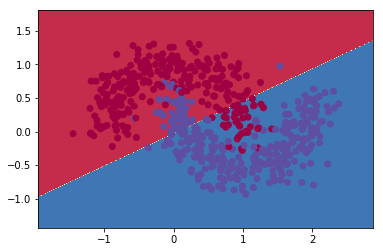

In [45]:
if __name__=="__main__":
    data = load_data('moons')
    sgd_optimization(LogisticRegression, data, learning_rate=0.05, n_epochs=400, draw_freq=25)

调整参数之后的分类效果要稍好于上一次, 而且不再产生显著的波动.

#### LINEAR

这是非常适合用这两种方式分类的情况.

dataset shape: (800, 2)


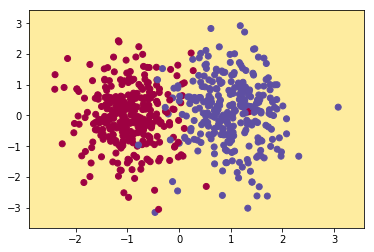

epoch is 0, train error 0.480000, test error 0.065000
epoch is 1, train error 0.041667, test error 0.055000
epoch is 2, train error 0.038333, test error 0.050000
epoch is 3, train error 0.038333, test error 0.045000
epoch is 4, train error 0.038333, test error 0.045000
epoch is 5, train error 0.036667, test error 0.045000
epoch is 6, train error 0.038333, test error 0.045000
epoch is 7, train error 0.038333, test error 0.045000
epoch is 8, train error 0.038333, test error 0.045000
epoch is 9, train error 0.038333, test error 0.045000
epoch is 10, train error 0.038333, test error 0.045000
epoch is 11, train error 0.038333, test error 0.045000
epoch is 12, train error 0.040000, test error 0.045000
epoch is 13, train error 0.040000, test error 0.045000
epoch is 14, train error 0.040000, test error 0.045000
epoch is 15, train error 0.040000, test error 0.045000
epoch is 16, train error 0.040000, test error 0.045000
epoch is 17, train error 0.040000, test error 0.045000
epoch is 18, train e

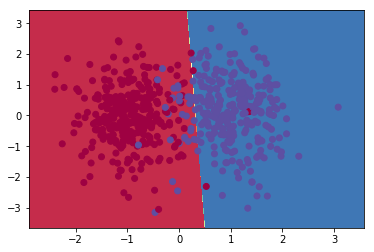

epoch is 25, train error 0.038333, test error 0.045000
epoch is 26, train error 0.038333, test error 0.045000
epoch is 27, train error 0.038333, test error 0.045000
epoch is 28, train error 0.038333, test error 0.045000
epoch is 29, train error 0.038333, test error 0.045000
epoch is 30, train error 0.040000, test error 0.045000
epoch is 31, train error 0.040000, test error 0.045000
epoch is 32, train error 0.040000, test error 0.045000
epoch is 33, train error 0.040000, test error 0.045000
epoch is 34, train error 0.040000, test error 0.045000
epoch is 35, train error 0.040000, test error 0.045000
epoch is 36, train error 0.040000, test error 0.045000
epoch is 37, train error 0.040000, test error 0.045000
epoch is 38, train error 0.040000, test error 0.045000
epoch is 39, train error 0.040000, test error 0.045000
epoch is 40, train error 0.040000, test error 0.045000
epoch is 41, train error 0.041667, test error 0.045000
epoch is 42, train error 0.041667, test error 0.045000
epoch is 4

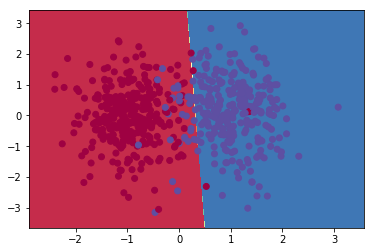

epoch is 50, train error 0.038333, test error 0.045000
epoch is 51, train error 0.038333, test error 0.045000
epoch is 52, train error 0.038333, test error 0.045000
epoch is 53, train error 0.038333, test error 0.045000
epoch is 54, train error 0.040000, test error 0.045000
epoch is 55, train error 0.040000, test error 0.045000
epoch is 56, train error 0.040000, test error 0.045000
epoch is 57, train error 0.040000, test error 0.045000
epoch is 58, train error 0.040000, test error 0.045000
epoch is 59, train error 0.040000, test error 0.045000
epoch is 60, train error 0.040000, test error 0.045000
epoch is 61, train error 0.040000, test error 0.045000
epoch is 62, train error 0.040000, test error 0.045000
epoch is 63, train error 0.040000, test error 0.045000
epoch is 64, train error 0.040000, test error 0.045000
epoch is 65, train error 0.040000, test error 0.045000
epoch is 66, train error 0.041667, test error 0.045000
epoch is 67, train error 0.041667, test error 0.045000
epoch is 6

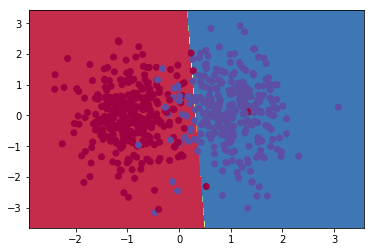

epoch is 75, train error 0.038333, test error 0.045000
epoch is 76, train error 0.038333, test error 0.045000
epoch is 77, train error 0.038333, test error 0.045000
epoch is 78, train error 0.038333, test error 0.045000
epoch is 79, train error 0.040000, test error 0.045000
epoch is 80, train error 0.040000, test error 0.045000
epoch is 81, train error 0.040000, test error 0.045000
epoch is 82, train error 0.040000, test error 0.045000
epoch is 83, train error 0.040000, test error 0.045000
epoch is 84, train error 0.040000, test error 0.045000
epoch is 85, train error 0.040000, test error 0.045000
epoch is 86, train error 0.040000, test error 0.045000
epoch is 87, train error 0.040000, test error 0.045000
epoch is 88, train error 0.040000, test error 0.045000
epoch is 89, train error 0.040000, test error 0.045000
epoch is 90, train error 0.040000, test error 0.045000
epoch is 91, train error 0.041667, test error 0.045000
epoch is 92, train error 0.041667, test error 0.045000
epoch is 9

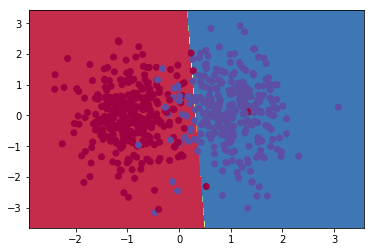

epoch is 100, train error 0.038333, test error 0.045000
epoch is 101, train error 0.038333, test error 0.045000
epoch is 102, train error 0.038333, test error 0.045000
epoch is 103, train error 0.038333, test error 0.045000
epoch is 104, train error 0.040000, test error 0.045000
epoch is 105, train error 0.040000, test error 0.045000
epoch is 106, train error 0.040000, test error 0.045000
epoch is 107, train error 0.040000, test error 0.045000
epoch is 108, train error 0.040000, test error 0.045000
epoch is 109, train error 0.040000, test error 0.045000
epoch is 110, train error 0.040000, test error 0.045000
epoch is 111, train error 0.040000, test error 0.045000
epoch is 112, train error 0.040000, test error 0.045000
epoch is 113, train error 0.040000, test error 0.045000
epoch is 114, train error 0.040000, test error 0.045000
epoch is 115, train error 0.040000, test error 0.045000
epoch is 116, train error 0.041667, test error 0.045000
epoch is 117, train error 0.041667, test error 0

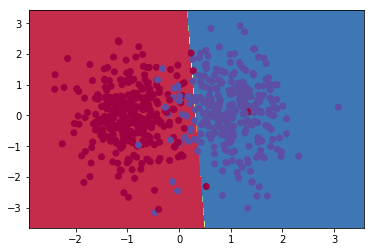

epoch is 125, train error 0.038333, test error 0.045000
epoch is 126, train error 0.038333, test error 0.045000
epoch is 127, train error 0.038333, test error 0.045000
epoch is 128, train error 0.038333, test error 0.045000
epoch is 129, train error 0.040000, test error 0.045000
epoch is 130, train error 0.040000, test error 0.045000
epoch is 131, train error 0.040000, test error 0.045000
epoch is 132, train error 0.040000, test error 0.045000
epoch is 133, train error 0.040000, test error 0.045000
epoch is 134, train error 0.040000, test error 0.045000
epoch is 135, train error 0.040000, test error 0.045000
epoch is 136, train error 0.040000, test error 0.045000
epoch is 137, train error 0.040000, test error 0.045000
epoch is 138, train error 0.040000, test error 0.045000
epoch is 139, train error 0.040000, test error 0.045000
epoch is 140, train error 0.040000, test error 0.045000
epoch is 141, train error 0.041667, test error 0.045000
epoch is 142, train error 0.041667, test error 0

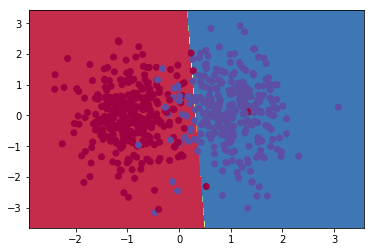

epoch is 150, train error 0.038333, test error 0.045000
epoch is 151, train error 0.038333, test error 0.045000
epoch is 152, train error 0.038333, test error 0.045000
epoch is 153, train error 0.038333, test error 0.045000
epoch is 154, train error 0.040000, test error 0.045000
epoch is 155, train error 0.040000, test error 0.045000
epoch is 156, train error 0.040000, test error 0.045000
epoch is 157, train error 0.040000, test error 0.045000
epoch is 158, train error 0.040000, test error 0.045000
epoch is 159, train error 0.040000, test error 0.045000
epoch is 160, train error 0.040000, test error 0.045000
epoch is 161, train error 0.040000, test error 0.045000
epoch is 162, train error 0.040000, test error 0.045000
epoch is 163, train error 0.040000, test error 0.045000
epoch is 164, train error 0.040000, test error 0.045000
epoch is 165, train error 0.040000, test error 0.045000
epoch is 166, train error 0.041667, test error 0.045000
epoch is 167, train error 0.041667, test error 0

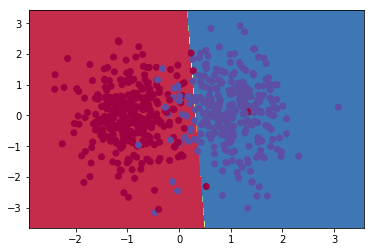

epoch is 175, train error 0.038333, test error 0.045000
epoch is 176, train error 0.038333, test error 0.045000
epoch is 177, train error 0.038333, test error 0.045000
epoch is 178, train error 0.038333, test error 0.045000
epoch is 179, train error 0.040000, test error 0.045000
epoch is 180, train error 0.040000, test error 0.045000
epoch is 181, train error 0.040000, test error 0.045000
epoch is 182, train error 0.040000, test error 0.045000
epoch is 183, train error 0.040000, test error 0.045000
epoch is 184, train error 0.040000, test error 0.045000
epoch is 185, train error 0.040000, test error 0.045000
epoch is 186, train error 0.040000, test error 0.045000
epoch is 187, train error 0.040000, test error 0.045000
epoch is 188, train error 0.040000, test error 0.045000
epoch is 189, train error 0.040000, test error 0.045000
epoch is 190, train error 0.040000, test error 0.045000
epoch is 191, train error 0.041667, test error 0.045000
epoch is 192, train error 0.041667, test error 0

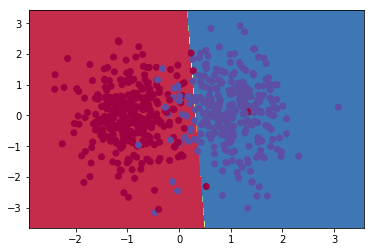

In [35]:
if __name__=="__main__":
    data = load_data('linear')
    sgd_optimization(LinearRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

dataset shape: (800, 2)


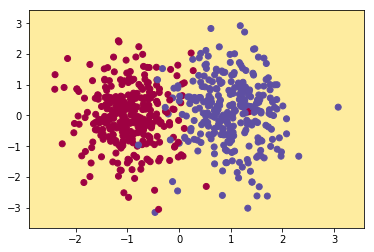

epoch is 0, train error 0.480000, test error 0.455000
epoch is 1, train error 0.376667, test error 0.125000
epoch is 2, train error 0.111667, test error 0.075000
epoch is 3, train error 0.066667, test error 0.055000
epoch is 4, train error 0.056667, test error 0.055000
epoch is 5, train error 0.048333, test error 0.050000
epoch is 6, train error 0.045000, test error 0.050000
epoch is 7, train error 0.043333, test error 0.050000
epoch is 8, train error 0.043333, test error 0.045000
epoch is 9, train error 0.043333, test error 0.045000
epoch is 10, train error 0.043333, test error 0.045000
epoch is 11, train error 0.043333, test error 0.050000
epoch is 12, train error 0.043333, test error 0.050000
epoch is 13, train error 0.043333, test error 0.050000
epoch is 14, train error 0.043333, test error 0.050000
epoch is 15, train error 0.045000, test error 0.050000
epoch is 16, train error 0.045000, test error 0.050000
epoch is 17, train error 0.045000, test error 0.050000
epoch is 18, train e

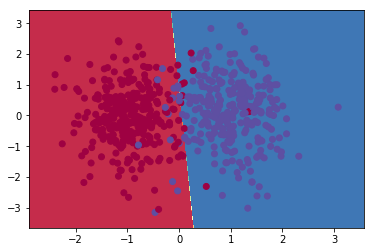

epoch is 25, train error 0.043333, test error 0.050000
epoch is 26, train error 0.043333, test error 0.050000
epoch is 27, train error 0.043333, test error 0.045000
epoch is 28, train error 0.043333, test error 0.045000
epoch is 29, train error 0.041667, test error 0.045000
epoch is 30, train error 0.043333, test error 0.045000
epoch is 31, train error 0.043333, test error 0.045000
epoch is 32, train error 0.041667, test error 0.045000
epoch is 33, train error 0.041667, test error 0.050000
epoch is 34, train error 0.041667, test error 0.050000
epoch is 35, train error 0.041667, test error 0.050000
epoch is 36, train error 0.043333, test error 0.050000
epoch is 37, train error 0.043333, test error 0.050000
epoch is 38, train error 0.043333, test error 0.050000
epoch is 39, train error 0.043333, test error 0.050000
epoch is 40, train error 0.043333, test error 0.050000
epoch is 41, train error 0.043333, test error 0.050000
epoch is 42, train error 0.043333, test error 0.050000
epoch is 4

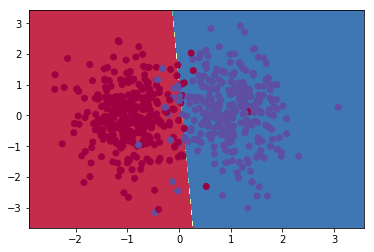

epoch is 50, train error 0.043333, test error 0.045000
epoch is 51, train error 0.041667, test error 0.045000
epoch is 52, train error 0.041667, test error 0.045000
epoch is 53, train error 0.041667, test error 0.045000
epoch is 54, train error 0.041667, test error 0.045000
epoch is 55, train error 0.041667, test error 0.045000
epoch is 56, train error 0.041667, test error 0.045000
epoch is 57, train error 0.041667, test error 0.045000
epoch is 58, train error 0.041667, test error 0.050000
epoch is 59, train error 0.041667, test error 0.050000
epoch is 60, train error 0.041667, test error 0.050000
epoch is 61, train error 0.041667, test error 0.050000
epoch is 62, train error 0.043333, test error 0.050000
epoch is 63, train error 0.043333, test error 0.050000
epoch is 64, train error 0.043333, test error 0.050000
epoch is 65, train error 0.043333, test error 0.050000
epoch is 66, train error 0.043333, test error 0.050000
epoch is 67, train error 0.043333, test error 0.050000
epoch is 6

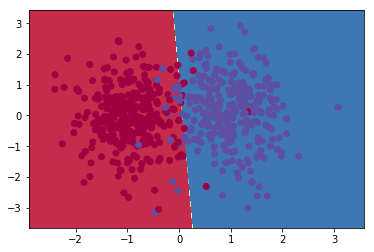

epoch is 75, train error 0.041667, test error 0.045000
epoch is 76, train error 0.041667, test error 0.045000
epoch is 77, train error 0.041667, test error 0.045000
epoch is 78, train error 0.040000, test error 0.045000
epoch is 79, train error 0.040000, test error 0.045000
epoch is 80, train error 0.040000, test error 0.045000
epoch is 81, train error 0.041667, test error 0.045000
epoch is 82, train error 0.041667, test error 0.045000
epoch is 83, train error 0.041667, test error 0.050000
epoch is 84, train error 0.041667, test error 0.050000
epoch is 85, train error 0.041667, test error 0.050000
epoch is 86, train error 0.041667, test error 0.050000
epoch is 87, train error 0.041667, test error 0.050000
epoch is 88, train error 0.041667, test error 0.050000
epoch is 89, train error 0.043333, test error 0.050000
epoch is 90, train error 0.043333, test error 0.050000
epoch is 91, train error 0.043333, test error 0.050000
epoch is 92, train error 0.043333, test error 0.050000
epoch is 9

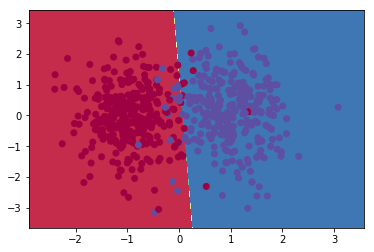

epoch is 100, train error 0.041667, test error 0.045000
epoch is 101, train error 0.041667, test error 0.045000
epoch is 102, train error 0.040000, test error 0.045000
epoch is 103, train error 0.040000, test error 0.045000
epoch is 104, train error 0.040000, test error 0.045000
epoch is 105, train error 0.040000, test error 0.045000
epoch is 106, train error 0.040000, test error 0.045000
epoch is 107, train error 0.040000, test error 0.045000
epoch is 108, train error 0.041667, test error 0.045000
epoch is 109, train error 0.041667, test error 0.050000
epoch is 110, train error 0.041667, test error 0.050000
epoch is 111, train error 0.041667, test error 0.050000
epoch is 112, train error 0.041667, test error 0.050000
epoch is 113, train error 0.041667, test error 0.050000
epoch is 114, train error 0.041667, test error 0.050000
epoch is 115, train error 0.041667, test error 0.050000
epoch is 116, train error 0.043333, test error 0.050000
epoch is 117, train error 0.043333, test error 0

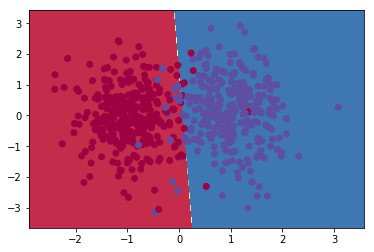

epoch is 125, train error 0.041667, test error 0.045000
epoch is 126, train error 0.041667, test error 0.045000
epoch is 127, train error 0.040000, test error 0.045000
epoch is 128, train error 0.040000, test error 0.045000
epoch is 129, train error 0.040000, test error 0.045000
epoch is 130, train error 0.040000, test error 0.045000
epoch is 131, train error 0.040000, test error 0.045000
epoch is 132, train error 0.040000, test error 0.045000
epoch is 133, train error 0.040000, test error 0.045000
epoch is 134, train error 0.041667, test error 0.050000
epoch is 135, train error 0.041667, test error 0.050000
epoch is 136, train error 0.041667, test error 0.050000
epoch is 137, train error 0.041667, test error 0.050000
epoch is 138, train error 0.041667, test error 0.050000
epoch is 139, train error 0.041667, test error 0.050000
epoch is 140, train error 0.041667, test error 0.050000
epoch is 141, train error 0.041667, test error 0.050000
epoch is 142, train error 0.041667, test error 0

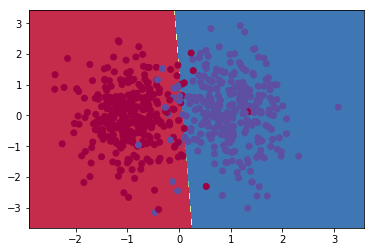

epoch is 150, train error 0.041667, test error 0.045000
epoch is 151, train error 0.040000, test error 0.045000
epoch is 152, train error 0.040000, test error 0.045000
epoch is 153, train error 0.040000, test error 0.045000
epoch is 154, train error 0.040000, test error 0.045000
epoch is 155, train error 0.040000, test error 0.045000
epoch is 156, train error 0.040000, test error 0.045000
epoch is 157, train error 0.040000, test error 0.045000
epoch is 158, train error 0.040000, test error 0.045000
epoch is 159, train error 0.040000, test error 0.045000
epoch is 160, train error 0.041667, test error 0.050000
epoch is 161, train error 0.041667, test error 0.050000
epoch is 162, train error 0.041667, test error 0.050000
epoch is 163, train error 0.041667, test error 0.050000
epoch is 164, train error 0.041667, test error 0.050000
epoch is 165, train error 0.041667, test error 0.050000
epoch is 166, train error 0.041667, test error 0.050000
epoch is 167, train error 0.041667, test error 0

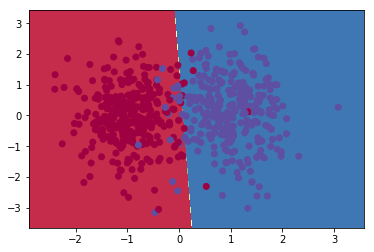

epoch is 175, train error 0.041667, test error 0.045000
epoch is 176, train error 0.040000, test error 0.045000
epoch is 177, train error 0.040000, test error 0.045000
epoch is 178, train error 0.040000, test error 0.045000
epoch is 179, train error 0.040000, test error 0.045000
epoch is 180, train error 0.040000, test error 0.045000
epoch is 181, train error 0.040000, test error 0.045000
epoch is 182, train error 0.040000, test error 0.045000
epoch is 183, train error 0.040000, test error 0.045000
epoch is 184, train error 0.040000, test error 0.045000
epoch is 185, train error 0.040000, test error 0.045000
epoch is 186, train error 0.040000, test error 0.050000
epoch is 187, train error 0.041667, test error 0.050000
epoch is 188, train error 0.041667, test error 0.050000
epoch is 189, train error 0.041667, test error 0.050000
epoch is 190, train error 0.041667, test error 0.050000
epoch is 191, train error 0.041667, test error 0.050000
epoch is 192, train error 0.041667, test error 0

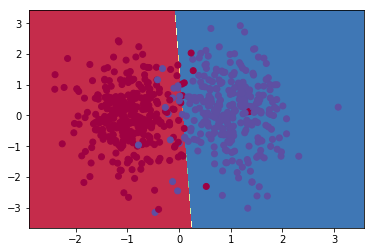

In [36]:
if __name__=="__main__":
    data = load_data('linear')
    sgd_optimization(LogisticRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

In [ ]:
对于可以较为精确的线性分类的情况, 两种方式没有体现出较大的差别. 线性回归在前几个epoch收敛的稍快一些.

#### CIRCLE

此数据集无法使用这两种分类器分类

dataset shape: (800, 2)


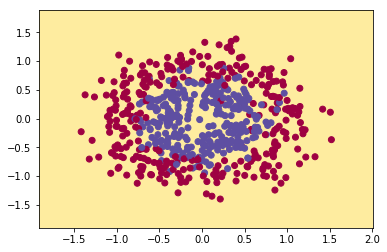

epoch is 0, train error 0.488333, test error 0.470000
epoch is 1, train error 0.511667, test error 0.485000
epoch is 2, train error 0.511667, test error 0.450000
epoch is 3, train error 0.510000, test error 0.510000
epoch is 4, train error 0.498333, test error 0.560000
epoch is 5, train error 0.478333, test error 0.555000
epoch is 6, train error 0.486667, test error 0.555000
epoch is 7, train error 0.485000, test error 0.555000
epoch is 8, train error 0.483333, test error 0.555000
epoch is 9, train error 0.486667, test error 0.555000
epoch is 10, train error 0.485000, test error 0.555000
epoch is 11, train error 0.486667, test error 0.555000
epoch is 12, train error 0.488333, test error 0.555000
epoch is 13, train error 0.486667, test error 0.555000
epoch is 14, train error 0.486667, test error 0.560000
epoch is 15, train error 0.486667, test error 0.560000
epoch is 16, train error 0.485000, test error 0.560000
epoch is 17, train error 0.485000, test error 0.560000
epoch is 18, train e

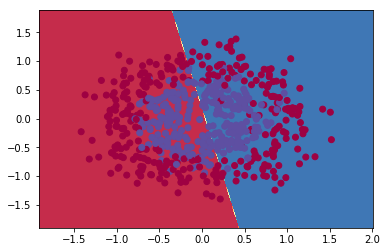

epoch is 25, train error 0.488333, test error 0.555000
epoch is 26, train error 0.491667, test error 0.560000
epoch is 27, train error 0.490000, test error 0.560000
epoch is 28, train error 0.488333, test error 0.560000
epoch is 29, train error 0.488333, test error 0.560000
epoch is 30, train error 0.486667, test error 0.560000
epoch is 31, train error 0.486667, test error 0.560000
epoch is 32, train error 0.486667, test error 0.560000
epoch is 33, train error 0.485000, test error 0.560000
epoch is 34, train error 0.486667, test error 0.560000
epoch is 35, train error 0.486667, test error 0.560000
epoch is 36, train error 0.488333, test error 0.560000
epoch is 37, train error 0.488333, test error 0.560000
epoch is 38, train error 0.488333, test error 0.560000
epoch is 39, train error 0.488333, test error 0.560000
epoch is 40, train error 0.488333, test error 0.560000
epoch is 41, train error 0.488333, test error 0.560000
epoch is 42, train error 0.488333, test error 0.560000
epoch is 4

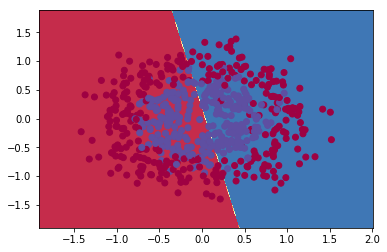

epoch is 50, train error 0.488333, test error 0.550000
epoch is 51, train error 0.490000, test error 0.555000
epoch is 52, train error 0.491667, test error 0.560000
epoch is 53, train error 0.491667, test error 0.560000
epoch is 54, train error 0.490000, test error 0.560000
epoch is 55, train error 0.488333, test error 0.560000
epoch is 56, train error 0.486667, test error 0.560000
epoch is 57, train error 0.486667, test error 0.560000
epoch is 58, train error 0.486667, test error 0.560000
epoch is 59, train error 0.485000, test error 0.560000
epoch is 60, train error 0.486667, test error 0.560000
epoch is 61, train error 0.486667, test error 0.560000
epoch is 62, train error 0.486667, test error 0.560000
epoch is 63, train error 0.486667, test error 0.560000
epoch is 64, train error 0.486667, test error 0.560000
epoch is 65, train error 0.486667, test error 0.560000
epoch is 66, train error 0.486667, test error 0.560000
epoch is 67, train error 0.488333, test error 0.560000
epoch is 6

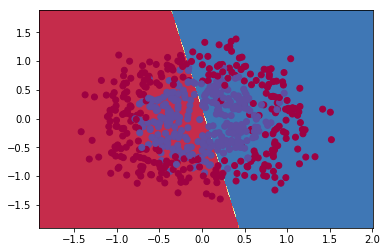

epoch is 75, train error 0.488333, test error 0.550000
epoch is 76, train error 0.488333, test error 0.550000
epoch is 77, train error 0.491667, test error 0.555000
epoch is 78, train error 0.491667, test error 0.560000
epoch is 79, train error 0.490000, test error 0.560000
epoch is 80, train error 0.488333, test error 0.560000
epoch is 81, train error 0.488333, test error 0.560000
epoch is 82, train error 0.486667, test error 0.560000
epoch is 83, train error 0.486667, test error 0.560000
epoch is 84, train error 0.486667, test error 0.560000
epoch is 85, train error 0.486667, test error 0.560000
epoch is 86, train error 0.486667, test error 0.560000
epoch is 87, train error 0.486667, test error 0.560000
epoch is 88, train error 0.486667, test error 0.560000
epoch is 89, train error 0.486667, test error 0.560000
epoch is 90, train error 0.486667, test error 0.560000
epoch is 91, train error 0.486667, test error 0.560000
epoch is 92, train error 0.486667, test error 0.560000
epoch is 9

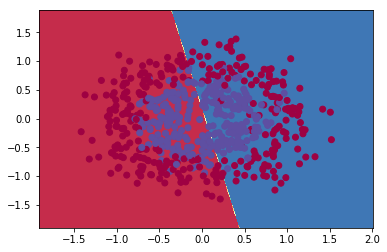

epoch is 100, train error 0.488333, test error 0.545000
epoch is 101, train error 0.488333, test error 0.550000
epoch is 102, train error 0.491667, test error 0.555000
epoch is 103, train error 0.491667, test error 0.560000
epoch is 104, train error 0.490000, test error 0.560000
epoch is 105, train error 0.490000, test error 0.560000
epoch is 106, train error 0.488333, test error 0.560000
epoch is 107, train error 0.486667, test error 0.560000
epoch is 108, train error 0.486667, test error 0.560000
epoch is 109, train error 0.486667, test error 0.560000
epoch is 110, train error 0.486667, test error 0.560000
epoch is 111, train error 0.486667, test error 0.560000
epoch is 112, train error 0.486667, test error 0.560000
epoch is 113, train error 0.485000, test error 0.560000
epoch is 114, train error 0.486667, test error 0.560000
epoch is 115, train error 0.486667, test error 0.560000
epoch is 116, train error 0.486667, test error 0.560000
epoch is 117, train error 0.486667, test error 0

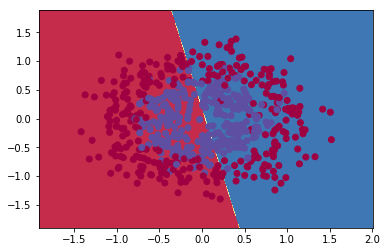

epoch is 125, train error 0.488333, test error 0.545000
epoch is 126, train error 0.488333, test error 0.550000
epoch is 127, train error 0.491667, test error 0.555000
epoch is 128, train error 0.491667, test error 0.560000
epoch is 129, train error 0.490000, test error 0.560000
epoch is 130, train error 0.490000, test error 0.560000
epoch is 131, train error 0.488333, test error 0.560000
epoch is 132, train error 0.488333, test error 0.560000
epoch is 133, train error 0.486667, test error 0.560000
epoch is 134, train error 0.486667, test error 0.560000
epoch is 135, train error 0.486667, test error 0.560000
epoch is 136, train error 0.486667, test error 0.560000
epoch is 137, train error 0.486667, test error 0.560000
epoch is 138, train error 0.485000, test error 0.560000
epoch is 139, train error 0.486667, test error 0.560000
epoch is 140, train error 0.486667, test error 0.560000
epoch is 141, train error 0.486667, test error 0.560000
epoch is 142, train error 0.486667, test error 0

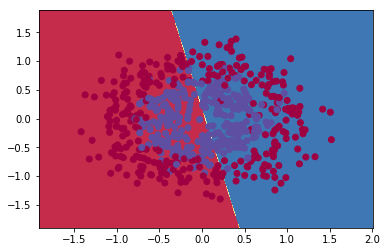

epoch is 150, train error 0.488333, test error 0.545000
epoch is 151, train error 0.488333, test error 0.550000
epoch is 152, train error 0.491667, test error 0.555000
epoch is 153, train error 0.491667, test error 0.560000
epoch is 154, train error 0.490000, test error 0.560000
epoch is 155, train error 0.490000, test error 0.560000
epoch is 156, train error 0.488333, test error 0.560000
epoch is 157, train error 0.488333, test error 0.560000
epoch is 158, train error 0.486667, test error 0.560000
epoch is 159, train error 0.486667, test error 0.560000
epoch is 160, train error 0.486667, test error 0.560000
epoch is 161, train error 0.486667, test error 0.560000
epoch is 162, train error 0.486667, test error 0.560000
epoch is 163, train error 0.485000, test error 0.560000
epoch is 164, train error 0.486667, test error 0.560000
epoch is 165, train error 0.486667, test error 0.560000
epoch is 166, train error 0.486667, test error 0.560000
epoch is 167, train error 0.486667, test error 0

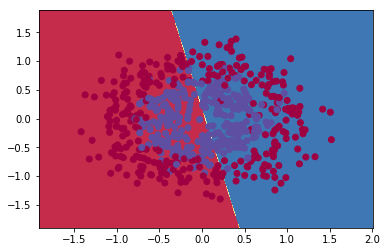

epoch is 175, train error 0.488333, test error 0.545000
epoch is 176, train error 0.488333, test error 0.550000
epoch is 177, train error 0.491667, test error 0.555000
epoch is 178, train error 0.491667, test error 0.560000
epoch is 179, train error 0.490000, test error 0.560000
epoch is 180, train error 0.490000, test error 0.560000
epoch is 181, train error 0.488333, test error 0.560000
epoch is 182, train error 0.488333, test error 0.560000
epoch is 183, train error 0.486667, test error 0.560000
epoch is 184, train error 0.486667, test error 0.560000
epoch is 185, train error 0.486667, test error 0.560000
epoch is 186, train error 0.486667, test error 0.560000
epoch is 187, train error 0.486667, test error 0.560000
epoch is 188, train error 0.485000, test error 0.560000
epoch is 189, train error 0.486667, test error 0.560000
epoch is 190, train error 0.486667, test error 0.560000
epoch is 191, train error 0.486667, test error 0.560000
epoch is 192, train error 0.486667, test error 0

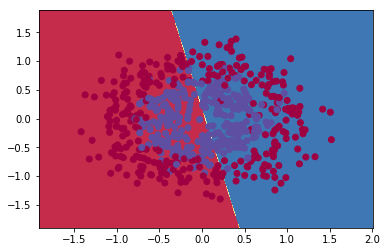

In [37]:
if __name__=="__main__":
    data = load_data('circles')
    sgd_optimization(LinearRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

dataset shape: (800, 2)


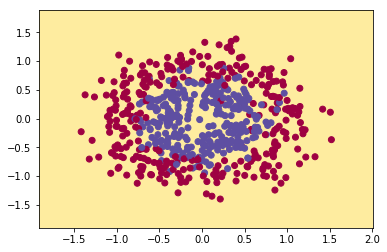

epoch is 0, train error 0.488333, test error 0.535000
epoch is 1, train error 0.488333, test error 0.535000
epoch is 2, train error 0.488333, test error 0.535000
epoch is 3, train error 0.488333, test error 0.535000
epoch is 4, train error 0.488333, test error 0.535000
epoch is 5, train error 0.488333, test error 0.535000
epoch is 6, train error 0.488333, test error 0.535000
epoch is 7, train error 0.488333, test error 0.535000
epoch is 8, train error 0.488333, test error 0.535000
epoch is 9, train error 0.488333, test error 0.535000
epoch is 10, train error 0.488333, test error 0.535000
epoch is 11, train error 0.488333, test error 0.535000
epoch is 12, train error 0.488333, test error 0.535000
epoch is 13, train error 0.488333, test error 0.535000
epoch is 14, train error 0.488333, test error 0.535000
epoch is 15, train error 0.488333, test error 0.535000
epoch is 16, train error 0.488333, test error 0.535000
epoch is 17, train error 0.488333, test error 0.535000
epoch is 18, train e

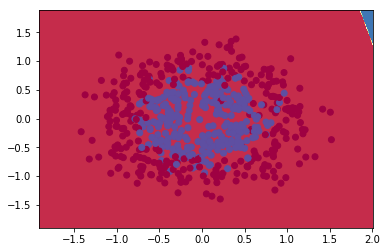

epoch is 25, train error 0.488333, test error 0.535000
epoch is 26, train error 0.488333, test error 0.535000
epoch is 27, train error 0.488333, test error 0.535000
epoch is 28, train error 0.488333, test error 0.535000
epoch is 29, train error 0.488333, test error 0.535000
epoch is 30, train error 0.488333, test error 0.535000
epoch is 31, train error 0.488333, test error 0.535000
epoch is 32, train error 0.488333, test error 0.535000
epoch is 33, train error 0.488333, test error 0.535000
epoch is 34, train error 0.488333, test error 0.535000
epoch is 35, train error 0.488333, test error 0.535000
epoch is 36, train error 0.488333, test error 0.535000
epoch is 37, train error 0.488333, test error 0.535000
epoch is 38, train error 0.488333, test error 0.535000
epoch is 39, train error 0.488333, test error 0.535000
epoch is 40, train error 0.488333, test error 0.535000
epoch is 41, train error 0.488333, test error 0.535000
epoch is 42, train error 0.488333, test error 0.535000
epoch is 4

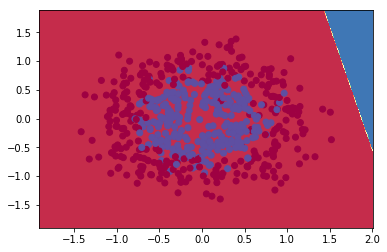

epoch is 50, train error 0.488333, test error 0.535000
epoch is 51, train error 0.488333, test error 0.535000
epoch is 52, train error 0.488333, test error 0.535000
epoch is 53, train error 0.488333, test error 0.535000
epoch is 54, train error 0.488333, test error 0.535000
epoch is 55, train error 0.488333, test error 0.535000
epoch is 56, train error 0.488333, test error 0.535000
epoch is 57, train error 0.488333, test error 0.535000
epoch is 58, train error 0.488333, test error 0.535000
epoch is 59, train error 0.488333, test error 0.535000
epoch is 60, train error 0.488333, test error 0.535000
epoch is 61, train error 0.488333, test error 0.535000
epoch is 62, train error 0.488333, test error 0.535000
epoch is 63, train error 0.488333, test error 0.535000
epoch is 64, train error 0.488333, test error 0.535000
epoch is 65, train error 0.488333, test error 0.535000
epoch is 66, train error 0.488333, test error 0.535000
epoch is 67, train error 0.488333, test error 0.535000
epoch is 6

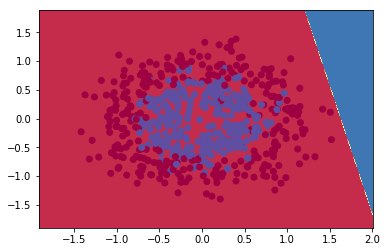

epoch is 75, train error 0.488333, test error 0.535000
epoch is 76, train error 0.488333, test error 0.535000
epoch is 77, train error 0.488333, test error 0.535000
epoch is 78, train error 0.488333, test error 0.535000
epoch is 79, train error 0.488333, test error 0.535000
epoch is 80, train error 0.488333, test error 0.535000
epoch is 81, train error 0.488333, test error 0.535000
epoch is 82, train error 0.488333, test error 0.535000
epoch is 83, train error 0.488333, test error 0.535000
epoch is 84, train error 0.488333, test error 0.535000
epoch is 85, train error 0.488333, test error 0.535000
epoch is 86, train error 0.488333, test error 0.535000
epoch is 87, train error 0.488333, test error 0.535000
epoch is 88, train error 0.488333, test error 0.535000
epoch is 89, train error 0.488333, test error 0.535000
epoch is 90, train error 0.488333, test error 0.535000
epoch is 91, train error 0.488333, test error 0.535000
epoch is 92, train error 0.488333, test error 0.535000
epoch is 9

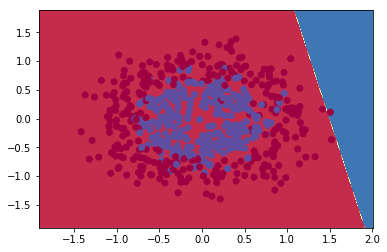

epoch is 100, train error 0.488333, test error 0.535000
epoch is 101, train error 0.488333, test error 0.535000
epoch is 102, train error 0.488333, test error 0.535000
epoch is 103, train error 0.488333, test error 0.535000
epoch is 104, train error 0.488333, test error 0.535000
epoch is 105, train error 0.488333, test error 0.535000
epoch is 106, train error 0.488333, test error 0.535000
epoch is 107, train error 0.488333, test error 0.535000
epoch is 108, train error 0.488333, test error 0.535000
epoch is 109, train error 0.488333, test error 0.535000
epoch is 110, train error 0.488333, test error 0.535000
epoch is 111, train error 0.488333, test error 0.535000
epoch is 112, train error 0.488333, test error 0.535000
epoch is 113, train error 0.488333, test error 0.535000
epoch is 114, train error 0.488333, test error 0.535000
epoch is 115, train error 0.488333, test error 0.535000
epoch is 116, train error 0.488333, test error 0.535000
epoch is 117, train error 0.488333, test error 0

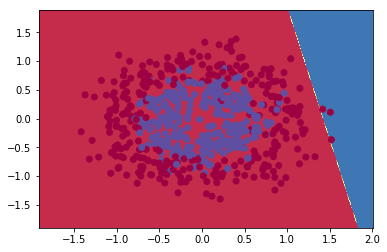

epoch is 125, train error 0.488333, test error 0.535000
epoch is 126, train error 0.488333, test error 0.535000
epoch is 127, train error 0.488333, test error 0.535000
epoch is 128, train error 0.488333, test error 0.535000
epoch is 129, train error 0.488333, test error 0.535000
epoch is 130, train error 0.488333, test error 0.535000
epoch is 131, train error 0.488333, test error 0.535000
epoch is 132, train error 0.488333, test error 0.535000
epoch is 133, train error 0.488333, test error 0.535000
epoch is 134, train error 0.488333, test error 0.535000
epoch is 135, train error 0.488333, test error 0.535000
epoch is 136, train error 0.488333, test error 0.535000
epoch is 137, train error 0.488333, test error 0.535000
epoch is 138, train error 0.488333, test error 0.535000
epoch is 139, train error 0.488333, test error 0.535000
epoch is 140, train error 0.488333, test error 0.535000
epoch is 141, train error 0.488333, test error 0.535000
epoch is 142, train error 0.488333, test error 0

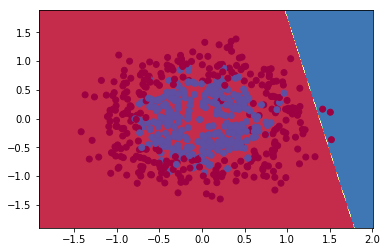

epoch is 150, train error 0.488333, test error 0.535000
epoch is 151, train error 0.488333, test error 0.535000
epoch is 152, train error 0.488333, test error 0.535000
epoch is 153, train error 0.488333, test error 0.535000
epoch is 154, train error 0.488333, test error 0.535000
epoch is 155, train error 0.488333, test error 0.535000
epoch is 156, train error 0.488333, test error 0.535000
epoch is 157, train error 0.488333, test error 0.535000
epoch is 158, train error 0.488333, test error 0.535000
epoch is 159, train error 0.488333, test error 0.535000
epoch is 160, train error 0.488333, test error 0.535000
epoch is 161, train error 0.488333, test error 0.535000
epoch is 162, train error 0.488333, test error 0.535000
epoch is 163, train error 0.488333, test error 0.535000
epoch is 164, train error 0.488333, test error 0.535000
epoch is 165, train error 0.488333, test error 0.535000
epoch is 166, train error 0.488333, test error 0.535000
epoch is 167, train error 0.488333, test error 0

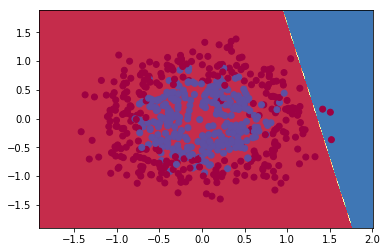

epoch is 175, train error 0.488333, test error 0.535000
epoch is 176, train error 0.488333, test error 0.535000
epoch is 177, train error 0.488333, test error 0.535000
epoch is 178, train error 0.488333, test error 0.535000
epoch is 179, train error 0.488333, test error 0.535000
epoch is 180, train error 0.488333, test error 0.535000
epoch is 181, train error 0.488333, test error 0.535000
epoch is 182, train error 0.488333, test error 0.535000
epoch is 183, train error 0.488333, test error 0.535000
epoch is 184, train error 0.488333, test error 0.535000
epoch is 185, train error 0.488333, test error 0.535000
epoch is 186, train error 0.488333, test error 0.535000
epoch is 187, train error 0.488333, test error 0.535000
epoch is 188, train error 0.488333, test error 0.535000
epoch is 189, train error 0.488333, test error 0.535000
epoch is 190, train error 0.488333, test error 0.535000
epoch is 191, train error 0.488333, test error 0.535000
epoch is 192, train error 0.488333, test error 0

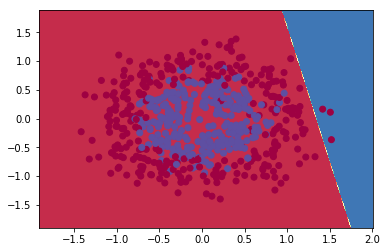

In [38]:
if __name__=="__main__":
    data = load_data('circles')
    sgd_optimization(LogisticRegression, data, learning_rate=0.1, n_epochs=200, draw_freq=25)

尽管都无法分类, 两种算法收敛在了不同的位置.

### 总结

在代码编写上, 两者的区别在于:

1. 分类依据的生成方式不同
1. 由此造成的损失函数不同

从分类效果上:

1. LogisticRegression在一些有异常点的地方更加鲁棒: LogisticRegression通过引入Sigmiod函数将分类过程中的概率限制在[0,1]范围之内, 而LinearReg因为没有类似的机制, 导致在出现异常数据点的时候所学习到的权重会受到很大的影响.

***

### Course Testing

In [39]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import tensorflow as tf

### Hello World

In [40]:
# input
x = tf.placeholder(tf.int32, [None], name='x')
hello = tf.constant("Hello world!")

# network
y = x

# data
data_x = np.ones(4)

# run
with tf.Session() as sess:
    output = sess.run(
        [y, hello],
        feed_dict = {x: data_x}
    )
    x_output, hello_output = output
    print(x_output)
    print(hello_output)

[1 1 1 1]
b'Hello world!'


In [41]:
a = tf.eye(3 ,name='a')
b = tf.ones(3, name='b')
c = tf.zeros([2,5], name='c')
d = tf.reshape(tf.range(6), [2,3], name='d')
e = tf.constant([1,2,3,4,5], name='e')
f = tf.constant(-1.0, shape=[2, 3], name='f')
var = [a,b,c,d,e,f]

sess = tf.Session()

output = sess.run(
    var,
    feed_dict = {x: np.ones(3)}
)

for k,v in zip(var, output):
    print(k)
    print(v)
    print()

sess.close()

Tensor("a_2/MatrixDiag:0", shape=(3, 3), dtype=float32)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Tensor("b_2:0", shape=(3,), dtype=float32)
[1. 1. 1.]

Tensor("c_2:0", shape=(2, 5), dtype=float32)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Tensor("d_2:0", shape=(2, 3), dtype=int32)
[[0 1 2]
 [3 4 5]]

Tensor("e_2:0", shape=(5,), dtype=int32)
[1 2 3 4 5]

Tensor("f_2:0", shape=(2, 3), dtype=float32)
[[-1. -1. -1.]
 [-1. -1. -1.]]

